In [72]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn import preprocessing
from collections import Counter
from sklearn import metrics

%matplotlib inline

## Dataset loading

In [45]:
def get_data(data_type, device, name, extension, sep):
    """
    data_type: type of data to return: Normal, Mirai, RouterSploit, UFONet
    device: the device name: archer, camera, indoor, philips, wr940n
    name: network or energy
    extension: file format
    sep: file delimiter
    """
    path = './QRS_dataset'
    types = {'mirai':'Mirai', 'normal':'Normal', 'rs':'RouterSploit', 'ufo':'UFONet'}

    if data_type in types.keys():
        data_type = types[data_type]
    
    if data_type not in os.listdir(path):
        print('Bad data type')
        return False
    
    path += f'/{data_type}'
    if data_type == 'Normal': 
        path += '/Normal'
    
    path += f'/{name}/{device}'
    
    if data_type == 'Normal': 
        path += '-normal1'
    else:
        path += '-attack1'

    path += extension

    return pd.read_csv(path, sep=sep, error_bad_lines=False)

def get_data_network(data_type, device):
    data = get_data(data_type, device, 'network', '.csv', ';')
    data.drop(['Info', 'No.'], axis=1, inplace=True)
    
    return data

def get_data_energy(data_type, device):
    data = get_data(data_type, device, 'energy', '.amp', ',')
    data['time'] /= 1000    # converting millis seconds
    data.drop('timestamp', axis=1, inplace=True)

    # rounding time to the nearest second
    data['time'] = data['time'].apply(round)
    data.drop_duplicates('time', inplace=True)
    data.reset_index(inplace=True, drop=True)

    return data

def get_data_and_preprocess(data_type, device):
    """
    data_type: type of data to return: Normal, Mirai, RouterSploit, UFONet
    device: the device name: archer, camera, indoor, philips, wr940n
    """
    data_network = get_data_network(data_type, device)
    data_energy = get_data_energy(data_type, device)

    # adding the energy usage for every packet
    data_network['Energy_Time'] = data_network['Time'].apply(round)
    data_network.drop(inplace=True, index=np.where(data_network['Energy_Time']>=data_energy['time'].max())[0])
    data_network['energy'] = list(data_energy.loc[list(data_network['Energy_Time']), 'energy'])
    data_network.drop('Energy_Time', axis=1, inplace=True)

    data_network['target'] = data_type

    data_network.reset_index(inplace=True, drop=True)

    return data_network, data_energy


In [46]:
normal_network, normal_energy = get_data_and_preprocess('normal', 'archer')
mirai_network, mirai_energy = get_data_and_preprocess('mirai', 'archer')

In [47]:
normal_network

,Time,Source,Destination,Protocol,Length,energy,target
0,0.000000,172.31.1.15,8.8.8.8,DNS,71,0.00,normal
1,0.020682,8.8.8.8,172.31.1.15,DNS,135,0.00,normal
2,5.002782,Tp-LinkT_81:9e:53,PcsCompu_73:1d:1d,ARP,60,0.14,normal
3,5.002810,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
4,5.053399,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
...,...,...,...,...,...,...,...
670,1783.318520,8.8.8.8,172.31.1.15,DNS,94,0.22,normal
671,1785.845176,172.31.1.15,8.8.8.8,DNS,68,0.22,normal
672,1785.858714,8.8.8.8,172.31.1.15,DNS,100,0.22,normal
673,1790.909397,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.21,normal


In [48]:
normal_energy

,energy,time
0,0.00,0
1,0.00,1
2,0.06,2
3,0.11,3
4,0.12,4
...,...,...
1792,0.22,1792
1793,0.22,1793
1794,0.22,1794
1795,0.23,1795


In [49]:
# Get both network datasets in the same time-frame

max_time = min(normal_network['Time'].max(), normal_network['Time'].max())

normal_network.drop(inplace=True, index=np.where(normal_network['Time']>max_time)[0])
normal_network.reset_index(inplace=True, drop=True)

mirai_network.drop(inplace=True, index=list(np.where(mirai_network['Time']>max_time)[0]))
mirai_network.reset_index(inplace=True, drop=True)

normal_energy.drop(inplace=True, index=np.where(normal_energy['time']>max_time)[0])
normal_energy.reset_index(inplace=True, drop=True)

mirai_energy.drop(inplace=True, index=list(np.where(mirai_energy['time']>max_time)[0]))
mirai_energy.reset_index(inplace=True, drop=True)

## Energy usage

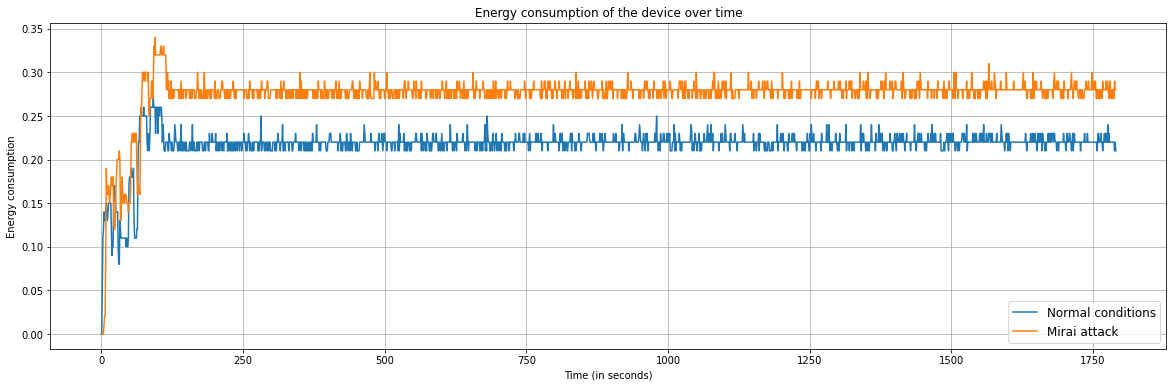

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)

ax.plot(normal_energy['time'], normal_energy['energy'], label='Normal conditions')
ax.plot(mirai_energy['time'], mirai_energy['energy'], label='Mirai attack')
ax.set_title('Energy consumption of the device over time')
ax.set_xlabel('Time (in seconds)')
ax.set_ylabel('Energy consumption')
ax.legend(loc=4, prop={'size': 12})
ax.grid()

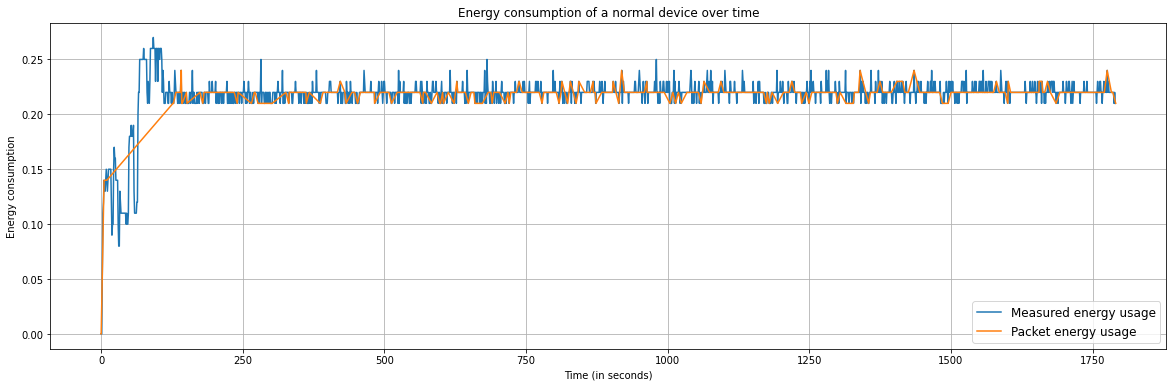

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)

max_time = min(normal_energy['time'].max(), mirai_energy['time'].max())

ax.plot(normal_energy['time'], normal_energy['energy'], label='Measured energy usage')
ax.plot(normal_network['Time'], normal_network['energy'], label='Packet energy usage')
ax.set_title('Energy consumption of a normal device over time')
ax.set_xlabel('Time (in seconds)')
ax.set_ylabel('Energy consumption')
ax.legend(loc=4, prop={'size': 12})
ax.grid()

## Protocol study

In [52]:
# normal_network = normal_network[normal_network.Protocol != 'ICMP']
# mirai_network = mirai_network[mirai_network.Protocol != 'ICMP']

print("Protocols:", normal_network['Protocol'].unique())

Protocols: ['DNS' 'ARP' 'DHCP' 'ICMP' 'TCP' 'TLSv1.2' 'NTP']


In [53]:
print("Count of the packets of each protocol")
df = pd.DataFrame()
df['Normal'] = normal_network.groupby('Protocol').count()['Length']
df['Mirai attack'] = mirai_network.groupby('Protocol').count()['Length']
df

Count of the packets of each protocol


,Normal,Mirai attack
Protocol,,
ARP,178,200
DHCP,12,12
DNS,430,464
ICMP,1,244
NTP,4,4
TCP,32,437950
TLSv1.2,18,30


<AxesSubplot:title={'center':'Bar graph for each protocol in normal communications'}, ylabel='Count'>

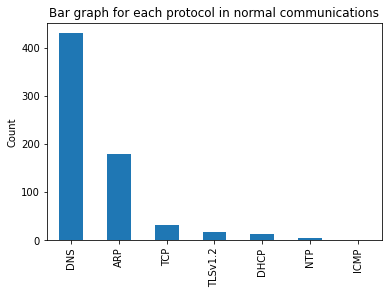

In [54]:
normal_network['Protocol'].value_counts().plot.bar(title="Bar graph for each protocol in normal communications", ylabel="Count")

In [55]:
# normal_network['TCP_Protocol'] = np.where(normal_network['Protocol'] == 'TCP', 1, 0)
# mirai_network['TCP_Protocol'] = np.where(mirai_network['Protocol'] == 'TCP', 1, 0)

## Getting data ready for the model

In [56]:
normal_network.corr()

,Time,Length,energy
Time,1.000000,-0.105717,0.104204
Length,-0.105717,1.000000,0.052379
energy,0.104204,0.052379,1.000000


In [57]:
Final_merge = normal_network.append(mirai_network)
Final_merge

,Time,Source,Destination,Protocol,Length,energy,target
0,0.000000,172.31.1.15,8.8.8.8,DNS,71,0.00,normal
1,0.020682,8.8.8.8,172.31.1.15,DNS,135,0.00,normal
2,5.002782,Tp-LinkT_81:9e:53,PcsCompu_73:1d:1d,ARP,60,0.14,normal
3,5.002810,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
4,5.053399,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
...,...,...,...,...,...,...,...
438901,1786.267402,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai
438902,1786.267408,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai
438903,1786.267413,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai
438904,1786.267417,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai


In [58]:
Final_merge.groupby('Protocol').count()

,Time,Source,Destination,Length,energy,target
Protocol,,,,,,
ARP,378,378,378,378,378,378
DHCP,24,24,24,24,24,24
DNS,894,894,894,894,894,894
ICMP,245,245,245,245,245,245
ICMPv6,2,2,2,2,2,2
NTP,8,8,8,8,8,8
TCP,437982,437982,437982,437982,437982,437982
TLSv1.2,48,48,48,48,48,48


In [59]:
Final_merge = Final_merge[Final_merge.Protocol != 0]

In [60]:
# protocol_type feature mapping
pmap = {'DNS':0, 'ARP':1, 'DHCP':2, 'ICMP':3, 'TCP':4, 'TLSv1.2':5, 'NTP':6, 'ICMPv6':7}
Final_merge['Protocol'] = Final_merge['Protocol'].map(pmap)

In [62]:
le = preprocessing.LabelEncoder()
Final_merge['Source'] = le.fit_transform(Final_merge.Source.values)
Final_merge['Destination'] = le.fit_transform(Final_merge.Destination.values)

In [63]:
Final_merge

,Time,Source,Destination,Protocol,Length,energy,target
0,0.000000,7,12,0,71,0.00,normal
1,0.020682,12,6,0,135,0.00,normal
2,5.002782,14,14,1,60,0.14,normal
3,5.002810,13,15,1,42,0.14,normal
4,5.053399,13,15,1,42,0.14,normal
...,...,...,...,...,...,...,...
438901,1786.267402,5,6,4,74,0.28,mirai
438902,1786.267408,5,6,4,74,0.28,mirai
438903,1786.267413,5,6,4,74,0.28,mirai
438904,1786.267417,5,6,4,74,0.28,mirai


In [64]:
Final_merge

,Time,Source,Destination,Protocol,Length,energy,target
0,0.000000,7,12,0,71,0.00,normal
1,0.020682,12,6,0,135,0.00,normal
2,5.002782,14,14,1,60,0.14,normal
3,5.002810,13,15,1,42,0.14,normal
4,5.053399,13,15,1,42,0.14,normal
...,...,...,...,...,...,...,...
438901,1786.267402,5,6,4,74,0.28,mirai
438902,1786.267408,5,6,4,74,0.28,mirai
438903,1786.267413,5,6,4,74,0.28,mirai
438904,1786.267417,5,6,4,74,0.28,mirai


In [71]:
Final_merge.to_csv('QRS_dataset/FinalSet.csv')

# The Model

In [67]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

In [68]:
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [74]:
# Model Accuracy, how often is the classifier correct?
print("Model Accuracy is:",metrics.accuclass)

class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_commonracy_score(y_test, y_pred)

AttributeError: module 'sklearn.metrics' has no attribute 'accuclass'

In [ ]:
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]

In [ ]:
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [ ]:
class RandomForest:
    
    def __init__(self, n_trees=10, min_samples_split=2,
                 max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                max_depth=self.max_depth, n_feats=self.n_feats)
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

In [ ]:
# Target variable and train set
y = Final_merge[['target']]
X = Final_merge.drop(['target', ], axis = 1)
  
# Split test and train data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.6, random_state = 42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

NameError: name 'Final_merge' is not defined

In [ ]:
clf = RandomForest(n_trees = 5)
clf.fit(X_train, y_train)

In [ ]:
clf_cv_score = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')

d:\Users\riadh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\Users\riadh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\Users\riadh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\Users\riadh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

In [ ]:
print("=================== Confusion Matrix ======================")
print(confusion_matrix(y_test, y_pred))
print('\n') 
print("=================== Classification Report =================")
print(classification_report(y_test, y_pred))
print('\n') 
print("=================== All AUC Scores =======================")
print(clf_cv_score)
print('\n') 
print("=================== Mean AUC Score =======================")
print("Mean AUC Score - Random Forest: ", clf_cv_score.mean())

=================== Confusion Matrix ======================
[[2223    2]
 [   1  243]]


=================== Classification Report =================
              precision    recall  f1-score   support

Mirai attack       1.00      1.00      1.00      2225
      Normal       0.99      1.00      0.99       244

    accuracy                           1.00      2469
   macro avg       1.00      1.00      1.00      2469
weighted avg       1.00      1.00      1.00      2469



=================== All AUC Scores =======================
[0.94542272 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


=================== Mean AUC Score =======================
Mean AUC Score - Random Forest:  0.9945422723100894


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

Mirai attack       1.00      1.00      1.00      2225
      Normal       0.99      1.00      0.99       244

    accuracy                           1.00      2469
   macro avg       1.00      1.00      1.00      2469
weighted avg       1.00      1.00      1.00      2469



In [ ]:
estimator = clf.estimators_[5]

In [ ]:
import time
from subprocess import check_output
import warnings


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# find best scored 5 features
select_feature = SelectKBest(chi2, k=5).fit(X_train, y_train)

In [ ]:
print('Score list:', select_feature.scores_)
print('Feature list:', X_train.columns)

Score list: [3.33047393e+05 1.71518454e+03 9.84512490e+02 1.20829673e+03
 3.30170056e+03 4.10670859e+02 6.96724956e+00 1.29638140e+09]
Feature list: Index(['Time', 'Source', 'Destination', 'Protocol', 'Length', 'TCP_Protocol',
       'energy', 'Energy_Time'],
      dtype='object')


In [ ]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

d:\Users\riadh\anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:241: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y)
d:\Users\riadh\anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:241: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y)
d:\Users\riadh\anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:241: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y)
d:\Users\riadh\anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:241: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

d:\Users\riadh\anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:241: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y)
d:\Users\riadh\anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:241: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y)
d:\Users\riadh\anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:241: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y)
d:\Users\riadh\anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:241: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

Optimal number of features : 2
Best features : Index(['Time', 'energy'], dtype='object')


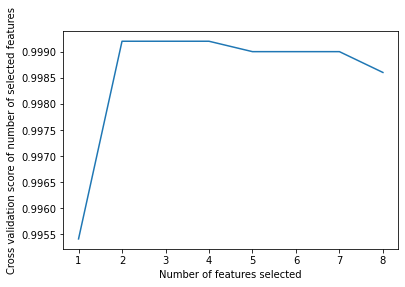

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

<ipython-input-87-7a1d768caae2>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clr_rf_5 = clf_rf_5.fit(X_train,y_train)


Feature ranking:
1. feature 6 (0.302515)
2. feature 0 (0.211578)
3. feature 5 (0.168457)
4. feature 1 (0.112348)
5. feature 3 (0.111781)
6. feature 7 (0.062927)
7. feature 2 (0.023541)
8. feature 4 (0.006854)


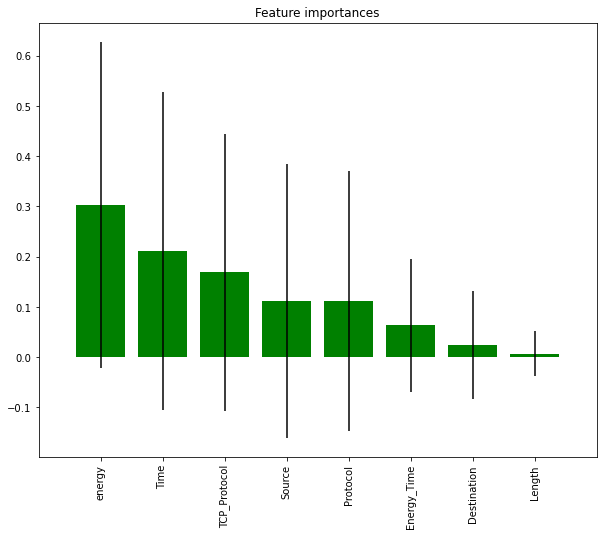

<Figure size 432x288 with 0 Axes>

In [ ]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(10, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()
plt.savefig('books_read.png')